In [1]:
# Importing relevant libraries

import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from IPython import display
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Flatten, Dropout

## Dataset

In [2]:
# data from: https://www.kaggle.com/ashishpatel26/facial-expression-recognitionferchallenge
# code from: https://www.tensorflow.org/tutorials/generative/dcgan

#data = pd.read_csv('C:/Users/97254/Documents/Generative_Models/project/datasets/fer2013.csv')
data = pd.read_csv('./fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [4]:
num_classes = 7
img_width = 48
img_height = 48

In [5]:
data.shape

(35887, 3)

In [6]:
X = data['pixels']
y = data['emotion']

In [7]:
X_train = []
for i in X:
    X_train.append([int(j) for j in i.split()])
    
X_train = np.array(X_train)/255.0

In [8]:
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_train = X_train.astype('float32')

In [9]:
X_train.shape

(35887, 48, 48, 1)

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator Model

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(12*12*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((12, 12, 256)))
    assert model.output_shape == (None, 12, 12, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 48, 48, 1)

    return model

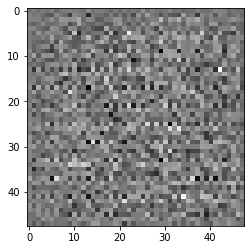

In [13]:
#Use the (as yet untrained) generator to create an image

generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36864)             3686400   
_________________________________________________________________
batch_normalization (BatchNo (None, 36864)             147456    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 36864)             0         
_________________________________________________________________
reshape (Reshape)            (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 128)       0

## Discriminator Model

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[48, 48, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00135051]], shape=(1, 1), dtype=float32)


In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)            

In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Computing the Losses

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

## Train

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(images):
    # generating noise from a normal distribution
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, gen_loss

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            disc_loss, gen_loss = train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        #print('Time for epoch {} is {} sec d={}, g={}'.format(epoch + 1, time.time() - start, disc_loss, gen_loss))
        print('Time for epoch %d: %.3f sec disc_loss=%.3f gen_loss=%.3f' % (epoch + 1, time.time() - start, disc_loss, gen_loss))
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [26]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

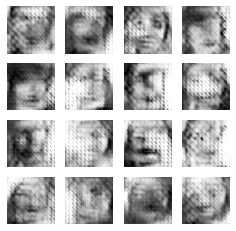

In [27]:
EPOCHS = 100
train(train_dataset, EPOCHS)